# Import libraries

In [1]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

### Other dependencies ###
from PIL import Image
from sklearn.preprocessing import OneHotEncoder

### Tensorflow dependencies ###
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy

### Some constants ###
input_dim = (48, 48, 3)
epochs = 3000
batch_size = 16
validation_size = 0.2

pnet_weights = 'weights/pnet.weights.hdf5'
rnet_weights = 'weights/rnet.weights.hdf5'
train_dir = "/home/minhhieu/Desktop/Hieu/datasets/RoadSignDetection/images"
test_dir = "/home/minhhieu/Desktop/Hieu/datasets/GTSDB/TestIJCNN2013/TestIJCNN2013Download"

# Load and explore dataset

[INFO] From images to ground truth ... 
[INFO] Converting to raw dataset ... 
[INFO] 1244 samples loaded ... 


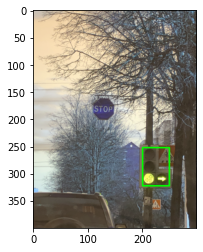

In [2]:
def load_raw_dataset(dataset_dir, gt_file, delimiter=';', max_n_samples=5000):
    '''
        This function will take in a dataset directory with ppm images (according to the DTSDB dataset)
        then it will return a list where each element is a list of 3 items. First item is the image, the
        second item is the bounding box and the last is the class ID.
        
        Params :
            @dataset_dir : Dataset directory.
            @gt_file : The file that consists of ground truth annotation in the format
            <img_pth>;<left>;<top>;<right>;<bottom>;<class_idx>.
            @delimiter : The separator of each item in each line of the ground truth file
            
        Returns :
            raw_dataset : list of elements [<cv2_img>, <gt_bbox>, <class_idx>]
    '''
    gt_abs_path = os.path.join(dataset_dir, gt_file)
    lines = open(gt_abs_path, 'r').readlines()
    
    print('[INFO] From images to ground truth ... ')
    images_to_gt = [[x.strip().split(delimiter)[0],   # Image path
                     x.strip().split(delimiter)[1:5], # Bbox regression ground truth
                     x.strip().split(delimiter)[5]]   # The class index
                    for x in lines]
    
    print('[INFO] Converting to raw dataset ... ')
    raw_dataset = [[cv2.imread(os.path.join(dataset_dir, x[0])),
                    np.array(x[1]).astype('int'),
                    int(x[2])]
                  for x in images_to_gt[:max_n_samples]]
    
    print(f'[INFO] {len(raw_dataset)} samples loaded ... ')
    
    return raw_dataset
    
raw_dataset = load_raw_dataset(train_dir, 'gt.txt')

### Visualize sample data ###
img = raw_dataset[1][0].copy()
bbox = raw_dataset[1][1]
x1, y1, x2, y2 = bbox
img = cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
plt.imshow(img)
plt.show()

### Generating negative samples (samples without traffic signs)

[INFO] 1244 negative samples generated ... 


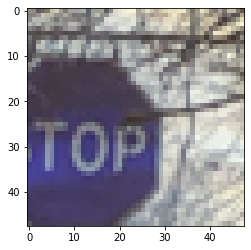

In [3]:
def generate_neg_samples(raw_dataset, crop_size=(48, 48)):
    '''
        This function will generate croppings of fixed size without any traffic sign
        and return those croppings with dummy bbox ground truth
        
        Params:
            @raw_dataset : The raw dataset formated similarly above
            @crop_size : The fixed cropping size
            
        Return:
            neg_samples : A list in format [<crop_img>,<dummy_bbox>,0]
    '''
    neg_samples = []
    for img, bbox, class_id in raw_dataset:
        height, width = img.shape[:2]
        x1, y1, x2, y2 = bbox
        range_x = ((0, max(x1 - crop_size[0], 0)), (min(x2 + crop_size[0], width), width))
        range_y = ((0, max(y1 - crop_size[1], 0)), (min(y2 + crop_size[1], height), height))
        
        ### Generate a random x,y coordinates ###
        x = random.choice([random.randint(range_x[0][0], range_x[0][1]), 
                           random.randint(range_x[1][0], range_x[1][1])])
        y = random.choice([random.randint(range_y[0][0], range_y[0][1]), 
                           random.randint(range_y[1][0], range_y[1][1])])
        
        # regenerate if cropping does not satisfy the size requirements
        while(width - x < crop_size[0] or height - y < crop_size[1]):
            x = random.choice([random.randint(range_x[0][0], range_x[0][1]), 
                           random.randint(range_x[1][0], range_x[1][1])])
            y = random.choice([random.randint(range_y[0][0], range_y[0][1]), 
                           random.randint(range_y[1][0], range_y[1][1])])
        
        crop = img[y:y+crop_size[1], x:x+crop_size[0]]
        neg_samples.append([crop, np.array([0,0,0,0]), 0])
        
    print(f'[INFO] {len(neg_samples)} negative samples generated ... ')
    return np.array(neg_samples)

neg_samples = generate_neg_samples(raw_dataset, crop_size=(48,48))
plt.imshow(neg_samples[1][0].copy())
plt.show()

### Generate positive samples (samles with traffic signs)

[INFO] 1244 positive samples generated ... 


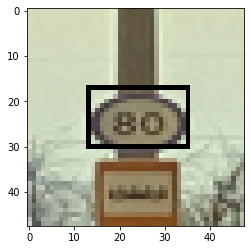

In [4]:
def generate_pos_samples(raw_dataset, pad_range=(10, 100), img_size=48):
    '''
        This function will generate croppings with traffic signs
        and return those croppings with bbox ground truth
        
        Params:
            @raw_dataset : The raw dataset formated similarly above
            @pad_range : The pad range around the ground truth bounding box
            
        Return:
            pos_samples : A list in format [<crop_img>,<bbox>,1]
    '''
    pos_samples = []
    for img, bbox, class_id in raw_dataset:
        height, width = img.shape[:2]
        x1, y1, x2, y2 = bbox
        pad_x1 = min(x1, random.randint(pad_range[0], pad_range[1]))
        pad_x2 = min(width - x2, random.randint(pad_range[0], pad_range[1]))
        pad_y1 = min(y1, random.randint(pad_range[0], pad_range[1]))
        pad_y2 = min(height - y2, random.randint(pad_range[0], pad_range[1]))
        
        crop = img[y1 - pad_y1:y2 + pad_y2, x1 - pad_x1:x2 + pad_x2]
        h, w = crop.shape[:2]
        
        gt = np.array([pad_x1, pad_y1, pad_x1 + x2 - x1, pad_y1 + y2 - y1])
        gt[2] = gt[2] - gt[0] # Calculates width
        gt[3] = gt[3] - gt[1] # Calculates height
        gt = np.multiply(gt, np.array([1/w, 1/h, 1/w, 1/h])).astype('float32')
        
        crop = cv2.resize(crop, (img_size, img_size))
        pos_samples.append([crop, gt, 1])
        
    print(f'[INFO] {len(pos_samples)} positive samples generated ... ')
    return np.array(pos_samples)

pos_samples = generate_pos_samples(raw_dataset, pad_range=(5, 50), img_size=48)

img, gt, label = pos_samples[6]
img = img.copy()
h, w = img.shape[:2]
x1, y1, w, h = np.multiply(gt, np.array([w,h,w,h])).astype('int')

img = cv2.rectangle(img, (x1, y1), (x1+w, y1+h), 2)
plt.imshow(img)
plt.show()

### Combine negative and positive samples to form training dataset

In [19]:
# Concatenate two groups and shuffle
train_dataset = np.concatenate([pos_samples, neg_samples])
np.random.shuffle(train_dataset)

images = np.array([x[0] for x in train_dataset])
bboxes = np.array([x[1] for x in train_dataset])
labels = OneHotEncoder().fit_transform(train_dataset[:,2].reshape(-1, 1)).toarray()

bboxes = bboxes.reshape(-1, 1, 1, 4)
labels = labels.reshape(-1, 1, 1, 2)

print(images.shape)
images = ((images - 127.5) / 127.5).astype('float32')
bboxes = bboxes.astype('float32')
labels = labels.astype('float32')

dataset_size = images.shape[0]
train_size = int(dataset_size * (1 - validation_size))

train_images = images[:train_size]
train_bboxes = bboxes[:train_size]
train_labels = labels[:train_size]

val_images = images[train_size:]
val_bboxes = bboxes[train_size:]
val_labels = labels[train_size:]

print(val_bboxes[:1])

(2488, 48, 48, 3)
[[[[0.16666667 0.31756756 0.5654762  0.6351351 ]]]]


# Implement R-Net architecture

In [20]:
def build_rnet_model(input_shape=None, batch_norm=True, dropout=False):
        if input_shape is None:
            input_shape = (24, 24, 3)

        r_inp = Input(input_shape)

        r_layer = Conv2D(28, kernel_size=(3, 3), strides=(1, 1), padding="valid")(r_inp)
        r_layer = PReLU(shared_axes=[1, 2])(r_layer)
        if(batch_norm) : p_layer = BatchNormalization()(r_layer)
        r_layer = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(r_layer)

        r_layer = Conv2D(48, kernel_size=(3, 3), strides=(1, 1), padding="valid")(r_layer)
        r_layer = PReLU(shared_axes=[1, 2])(r_layer)
        if(batch_norm) : p_layer = BatchNormalization()(r_layer)
        r_layer = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="valid")(r_layer)

        r_layer = Conv2D(64, kernel_size=(2, 2), strides=(1, 1), padding="valid")(r_layer)
        r_layer = PReLU(shared_axes=[1, 2])(r_layer)
        if(batch_norm) : p_layer = BatchNormalization()(r_layer)
            
            
        r_layer = Flatten()(r_layer)
        if(dropout) : p_layer = Dropout(0.5)(r_layer)
            
        r_layer = Dense(128)(r_layer)
        r_layer = PReLU()(r_layer)

        r_layer_out1 = Dense(2)(r_layer)
        r_layer_out1 = Softmax(axis=1, name='probability')(r_layer_out1)

        r_layer_out2 = Dense(4, activation='sigmoid', name='bbox_regression')(r_layer)

        r_net = Model(r_inp, [r_layer_out2, r_layer_out1])

        return r_net

def build_pnet_model(batch_norm=True, dropout=False):
    inputs = Input(shape=(None, None, 3))
    
    p_layer = Conv2D(10, kernel_size=(3, 3), strides=(1, 1), padding="valid", kernel_regularizer=l2(2e-4))(inputs)
    p_layer = PReLU(shared_axes=[1, 2])(p_layer)
    if(batch_norm) : p_layer = BatchNormalization()(p_layer)
    p_layer = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(p_layer)

    p_layer = Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding="valid", kernel_regularizer=l2(2e-4))(p_layer)
    p_layer = PReLU(shared_axes=[1, 2])(p_layer)
    if(batch_norm) : p_layer = BatchNormalization()(p_layer)

    p_layer = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding="valid", kernel_regularizer=l2(2e-4))(p_layer)
    p_layer = PReLU(shared_axes=[1, 2])(p_layer)
    if(dropout) : p_layer = Dropout(0.5)(p_layer)

    p_layer_out1 = Conv2D(2, kernel_size=(1, 1), strides=(1, 1))(p_layer)
    p_layer_out1 = Softmax(axis=3, name='probability')(p_layer_out1)

    p_layer_out2 = Conv2D(4, kernel_size=(1, 1), strides=(1, 1), activation='sigmoid', name='bbox_regression')(p_layer)

    p_net = Model(inputs, [p_layer_out1, p_layer_out2], name='P-Net')

    return p_net

pnet = build_pnet_model(batch_norm=False, dropout=True)
rnet = build_rnet_model(input_shape=input_dim, batch_norm=False, dropout=True)
print(rnet.summary())

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 46, 46, 28)   784         input_5[0][0]                    
__________________________________________________________________________________________________
p_re_lu_10 (PReLU)              (None, 46, 46, 28)   28          conv2d_12[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 23, 23, 28)   0           p_re_lu_10[0][0]                 
_______________________________________________________________________________________

# Start training

In [22]:
def get_custom_bbox_regression_loss(reduction='sum', batch_size=16):
    def custom_bbox_regression_loss(y_true, y_pred, reduction=reduction, batch_size=batch_size):
        '''
            This function customize bounding box regression loss by taking sum of the 
            l2 loss of the top left corner coordinates and the log of the ration between
            predicted and ground truth width/height.

            Params :
                - y_true : ground truth bounding boxes.
                - y_pred : predicted bounding boxes.

            Return :
                - loss : custom bbox regression loss
        '''
        def get_mask(batch_size, col_id=0):
            a = np.zeros((batch_size, 4), dtype=np.float32)
            a[:, col_id] = 1
            a = tf.convert_to_tensor(a)

            return a

        y_true = tf.reshape(y_true, [-1, 4])
        y_pred = tf.reshape(y_pred, [-1, 4])

        if(reduction == 'sum'):
            reduction = K.sum
        elif(reduction == 'mean'):
            reduction = K.mean
        else:
            reduction = K.mean

        if(isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray)):
            x_gt, y_gt, w_gt, h_gt = y_true[:,0], y_true[:,1], y_true[:,2], y_true[:,3]
            x_pr, y_pr, w_pr, h_pr = y_pred[:,0], y_pred[:,1], y_pred[:,2], y_pred[:,3]
        else:
            x_gt = K.sum(tf.multiply(y_true, get_mask(batch_size, col_id=0)), axis=1, keepdims=True) 
            y_gt = K.sum(tf.multiply(y_true, get_mask(batch_size, col_id=1)), axis=1, keepdims=True) 
            w_gt = K.sum(tf.multiply(y_true, get_mask(batch_size, col_id=2)), axis=1, keepdims=True) 
            h_gt = K.sum(tf.multiply(y_true, get_mask(batch_size, col_id=3)), axis=1, keepdims=True) 

            x_pr = K.sum(tf.multiply(y_pred, get_mask(batch_size, col_id=0)), axis=1, keepdims=True) 
            y_pr = K.sum(tf.multiply(y_pred, get_mask(batch_size, col_id=1)), axis=1, keepdims=True) 
            w_pr = K.sum(tf.multiply(y_pred, get_mask(batch_size, col_id=2)), axis=1, keepdims=True) 
            h_pr = K.sum(tf.multiply(y_pred, get_mask(batch_size, col_id=3)), axis=1, keepdims=True) 

        l2_loss = reduction((x_gt - x_pr) ** 2) + reduction((y_gt - y_pr) ** 2)
        log_loss = reduction(K.binary_crossentropy(w_gt, w_pr)) + reduction(K.binary_crossentropy(h_gt, h_pr))
        # log_loss = reduction((K.sqrt(w_gt) - K.sqrt(w_pr)) ** 2) + reduction((K.sqrt(h_gt) - K.sqrt(h_pr))**2)
        loss = l2_loss + log_loss

        return loss

    return custom_bbox_regression_loss


# # Start training
losses_1 = {
    'probability' : BinaryCrossentropy(),
    'bbox_regression' : get_custom_bbox_regression_loss(batch_size=batch_size, reduction='sum')
}

losses_2 = {
    'probability' : BinaryCrossentropy(),
    'bbox_regression' : get_custom_bbox_regression_loss(batch_size=batch_size, reduction='mean') 
}
 
loss_weights = {
    'probability' : 1.0,
    'bbox_regression' : 0.5
}

y_train = {
    'probability' : train_labels,
    'bbox_regression' : train_bboxes
}

y_val = {
    'probability' : val_labels,
    'bbox_regression' : val_bboxes
}
 
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, y_train))
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, y_val))
val_dataset = val_dataset.batch(batch_size, drop_remainder=True)


if(os.path.exists(rnet_weights)):
    print('[INFO] Loading R-Net pretrained weights ...')
    rnet.load_weights(rnet_weights)

[INFO] Loading R-Net pretrained weights ...


In [23]:
tensorboard = TensorBoard(log_dir="./logs")
checkpoint = ModelCheckpoint(rnet_weights, save_weights_only=True)

### Schedule 1 ###
print('[INFO] Begining schedule #1 ... ')
rnet.compile(optimizer=Adam(lr=0.00001, amsgrad=True),
            loss=losses_1,
            loss_weights=loss_weights,
            metrics={'probability':'accuracy'})

history = rnet.fit(train_dataset, epochs=epochs//2, 
        batch_size=batch_size, 
        validation_data=val_dataset, validation_batch_size=batch_size, 
        callbacks=[tensorboard, checkpoint])

### Schedule  2 ###
print('[INFO] Begining schedule #2 ...')
rnet.compile(optimizer=Adam(lr=0.0000001, amsgrad=True),
            loss=losses_2,
            loss_weights=loss_weights,
            metrics={'probability':'accuracy'})

history = rnet.fit(train_dataset, initial_epoch=epochs//2,
        epochs=epochs , batch_size=batch_size, 
        validation_data=val_dataset, validation_batch_size=batch_size, 
        callbacks=[tensorboard, checkpoint])


[INFO] Begining schedule #1 ... 
Epoch 1/125
124/124 [==============================] - 1s 4ms/step - loss: 11.0421 - bbox_regression_loss: 20.6952 - probability_loss: 0.6945 - probability_accuracy: 0.5143 - val_loss: 9.6184 - val_bbox_regression_loss: 17.8342 - val_probability_loss: 0.7014 - val_probability_accuracy: 0.4929
Epoch 2/125
124/124 [==============================] - 0s 2ms/step - loss: 9.2130 - bbox_regression_loss: 17.0366 - probability_loss: 0.6947 - probability_accuracy: 0.5092 - val_loss: 8.6879 - val_bbox_regression_loss: 15.9777 - val_probability_loss: 0.6990 - val_probability_accuracy: 0.4914
Epoch 3/125
124/124 [==============================] - 0s 2ms/step - loss: 8.5593 - bbox_regression_loss: 15.7294 - probability_loss: 0.6945 - probability_accuracy: 0.5072 - val_loss: 8.2869 - val_bbox_regression_loss: 15.1771 - val_probability_loss: 0.6984 - val_probability_accuracy: 0.4965
Epoch 4/125
124/124 [==============================] - 0s 2ms/step - loss: 8.2458 - bbo

Epoch 28/125
124/124 [==============================] - 0s 2ms/step - loss: 7.0210 - bbox_regression_loss: 12.6548 - probability_loss: 0.6935 - probability_accuracy: 0.5170 - val_loss: 7.1526 - val_bbox_regression_loss: 12.9022 - val_probability_loss: 0.7015 - val_probability_accuracy: 0.5000
Epoch 29/125
124/124 [==============================] - 0s 2ms/step - loss: 7.0074 - bbox_regression_loss: 12.6279 - probability_loss: 0.6935 - probability_accuracy: 0.5173 - val_loss: 7.1432 - val_bbox_regression_loss: 12.8833 - val_probability_loss: 0.7016 - val_probability_accuracy: 0.5003
Epoch 30/125
124/124 [==============================] - 0s 2ms/step - loss: 6.9945 - bbox_regression_loss: 12.6021 - probability_loss: 0.6934 - probability_accuracy: 0.5178 - val_loss: 7.1340 - val_bbox_regression_loss: 12.8648 - val_probability_loss: 0.7016 - val_probability_accuracy: 0.5000
Epoch 31/125
124/124 [==============================] - 0s 2ms/step - loss: 6.9820 - bbox_regression_loss: 12.5773 - p

Epoch 56/125
124/124 [==============================] - 0s 2ms/step - loss: 6.7606 - bbox_regression_loss: 12.1367 - probability_loss: 0.6922 - probability_accuracy: 0.5231 - val_loss: 6.9880 - val_bbox_regression_loss: 12.5712 - val_probability_loss: 0.7024 - val_probability_accuracy: 0.4967
Epoch 57/125
124/124 [==============================] - 0s 2ms/step - loss: 6.7539 - bbox_regression_loss: 12.1234 - probability_loss: 0.6922 - probability_accuracy: 0.5231 - val_loss: 6.9848 - val_bbox_regression_loss: 12.5647 - val_probability_loss: 0.7024 - val_probability_accuracy: 0.4967
Epoch 58/125
124/124 [==============================] - 0s 2ms/step - loss: 6.7472 - bbox_regression_loss: 12.1101 - probability_loss: 0.6921 - probability_accuracy: 0.5234 - val_loss: 6.9817 - val_bbox_regression_loss: 12.5584 - val_probability_loss: 0.7025 - val_probability_accuracy: 0.4967
Epoch 59/125
124/124 [==============================] - 0s 2ms/step - loss: 6.7406 - bbox_regression_loss: 12.0971 - p

Epoch 84/125
124/124 [==============================] - 0s 2ms/step - loss: 6.6039 - bbox_regression_loss: 11.8255 - probability_loss: 0.6912 - probability_accuracy: 0.5292 - val_loss: 6.9279 - val_bbox_regression_loss: 12.4494 - val_probability_loss: 0.7032 - val_probability_accuracy: 0.4955
Epoch 85/125
124/124 [==============================] - 0s 2ms/step - loss: 6.5992 - bbox_regression_loss: 11.8162 - probability_loss: 0.6912 - probability_accuracy: 0.5297 - val_loss: 6.9263 - val_bbox_regression_loss: 12.4462 - val_probability_loss: 0.7031 - val_probability_accuracy: 0.4955
Epoch 86/125
124/124 [==============================] - 0s 2ms/step - loss: 6.5946 - bbox_regression_loss: 11.8070 - probability_loss: 0.6911 - probability_accuracy: 0.5295 - val_loss: 6.9250 - val_bbox_regression_loss: 12.4436 - val_probability_loss: 0.7032 - val_probability_accuracy: 0.4955
Epoch 87/125
124/124 [==============================] - 0s 2ms/step - loss: 6.5900 - bbox_regression_loss: 11.7978 - p

Epoch 112/125
124/124 [==============================] - 0s 2ms/step - loss: 6.4865 - bbox_regression_loss: 11.5923 - probability_loss: 0.6903 - probability_accuracy: 0.5323 - val_loss: 6.8957 - val_bbox_regression_loss: 12.3844 - val_probability_loss: 0.7035 - val_probability_accuracy: 0.4962
Epoch 113/125
124/124 [==============================] - 0s 2ms/step - loss: 6.4827 - bbox_regression_loss: 11.5848 - probability_loss: 0.6903 - probability_accuracy: 0.5330 - val_loss: 6.8947 - val_bbox_regression_loss: 12.3823 - val_probability_loss: 0.7035 - val_probability_accuracy: 0.4962
Epoch 114/125
124/124 [==============================] - 0s 2ms/step - loss: 6.4789 - bbox_regression_loss: 11.5774 - probability_loss: 0.6903 - probability_accuracy: 0.5329 - val_loss: 6.8936 - val_bbox_regression_loss: 12.3802 - val_probability_loss: 0.7035 - val_probability_accuracy: 0.4967
Epoch 115/125
124/124 [==============================] - 0s 2ms/step - loss: 6.4753 - bbox_regression_loss: 11.5702

Epoch 139/250
124/124 [==============================] - 0s 2ms/step - loss: 1.0475 - bbox_regression_loss: 0.7170 - probability_loss: 0.6890 - probability_accuracy: 0.5389 - val_loss: 1.0840 - val_bbox_regression_loss: 0.7713 - val_probability_loss: 0.6984 - val_probability_accuracy: 0.5033
Epoch 140/250
124/124 [==============================] - 0s 2ms/step - loss: 1.0475 - bbox_regression_loss: 0.7170 - probability_loss: 0.6890 - probability_accuracy: 0.5389 - val_loss: 1.0841 - val_bbox_regression_loss: 0.7713 - val_probability_loss: 0.6984 - val_probability_accuracy: 0.5033
Epoch 141/250
124/124 [==============================] - 0s 2ms/step - loss: 1.0475 - bbox_regression_loss: 0.7170 - probability_loss: 0.6890 - probability_accuracy: 0.5389 - val_loss: 1.0841 - val_bbox_regression_loss: 0.7713 - val_probability_loss: 0.6984 - val_probability_accuracy: 0.5033
Epoch 142/250
124/124 [==============================] - 0s 2ms/step - loss: 1.0475 - bbox_regression_loss: 0.7170 - prob

Epoch 167/250
124/124 [==============================] - 0s 2ms/step - loss: 1.0474 - bbox_regression_loss: 0.7169 - probability_loss: 0.6889 - probability_accuracy: 0.5395 - val_loss: 1.0841 - val_bbox_regression_loss: 0.7715 - val_probability_loss: 0.6984 - val_probability_accuracy: 0.5030
Epoch 168/250
124/124 [==============================] - 0s 2ms/step - loss: 1.0474 - bbox_regression_loss: 0.7169 - probability_loss: 0.6889 - probability_accuracy: 0.5395 - val_loss: 1.0841 - val_bbox_regression_loss: 0.7715 - val_probability_loss: 0.6984 - val_probability_accuracy: 0.5030
Epoch 169/250
124/124 [==============================] - 0s 2ms/step - loss: 1.0473 - bbox_regression_loss: 0.7169 - probability_loss: 0.6889 - probability_accuracy: 0.5395 - val_loss: 1.0841 - val_bbox_regression_loss: 0.7715 - val_probability_loss: 0.6984 - val_probability_accuracy: 0.5030
Epoch 170/250
124/124 [==============================] - 0s 2ms/step - loss: 1.0473 - bbox_regression_loss: 0.7169 - prob

Epoch 195/250
124/124 [==============================] - 0s 2ms/step - loss: 1.0473 - bbox_regression_loss: 0.7168 - probability_loss: 0.6889 - probability_accuracy: 0.5397 - val_loss: 1.0841 - val_bbox_regression_loss: 0.7715 - val_probability_loss: 0.6984 - val_probability_accuracy: 0.5025
Epoch 196/250
124/124 [==============================] - 0s 2ms/step - loss: 1.0473 - bbox_regression_loss: 0.7168 - probability_loss: 0.6889 - probability_accuracy: 0.5398 - val_loss: 1.0841 - val_bbox_regression_loss: 0.7715 - val_probability_loss: 0.6984 - val_probability_accuracy: 0.5025
Epoch 197/250
124/124 [==============================] - 0s 2ms/step - loss: 1.0473 - bbox_regression_loss: 0.7167 - probability_loss: 0.6889 - probability_accuracy: 0.5396 - val_loss: 1.0841 - val_bbox_regression_loss: 0.7715 - val_probability_loss: 0.6984 - val_probability_accuracy: 0.5025
Epoch 198/250
124/124 [==============================] - 0s 2ms/step - loss: 1.0472 - bbox_regression_loss: 0.7167 - prob

Epoch 223/250
124/124 [==============================] - 0s 2ms/step - loss: 1.0472 - bbox_regression_loss: 0.7166 - probability_loss: 0.6888 - probability_accuracy: 0.5398 - val_loss: 1.0841 - val_bbox_regression_loss: 0.7715 - val_probability_loss: 0.6984 - val_probability_accuracy: 0.5023
Epoch 224/250
124/124 [==============================] - 0s 2ms/step - loss: 1.0472 - bbox_regression_loss: 0.7166 - probability_loss: 0.6888 - probability_accuracy: 0.5398 - val_loss: 1.0841 - val_bbox_regression_loss: 0.7715 - val_probability_loss: 0.6984 - val_probability_accuracy: 0.5018
Epoch 225/250
124/124 [==============================] - 0s 2ms/step - loss: 1.0472 - bbox_regression_loss: 0.7166 - probability_loss: 0.6888 - probability_accuracy: 0.5398 - val_loss: 1.0841 - val_bbox_regression_loss: 0.7715 - val_probability_loss: 0.6984 - val_probability_accuracy: 0.5018
Epoch 226/250
124/124 [==============================] - 0s 2ms/step - loss: 1.0472 - bbox_regression_loss: 0.7166 - prob

# Test P-Net proposals

In [24]:
def __nms(boxes, s, threshold, method):
    """
        Non Maximum Suppression.

        Params:
            @param boxes: np array with bounding boxes.
            @param threshold:
            @param method: NMS method to apply. Available values ('Min', 'Union')
        
        Return:
            pick : An array of indices selected.
    """
    if boxes.size == 0:
        return np.empty((0, 3))

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2] + x1
    y2 = boxes[:, 3] + y1

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    sorted_s = np.argsort(s)

    pick = np.zeros_like(s, dtype=np.int16)
    counter = 0
    while sorted_s.size > 0:
        i = sorted_s[-1]
        pick[counter] = i
        counter += 1
        idx = sorted_s[0:-1]

        xx1 = np.maximum(x1[i], x1[idx])
        yy1 = np.maximum(y1[i], y1[idx])
        xx2 = np.minimum(x2[i], x2[idx])
        yy2 = np.minimum(y2[i], y2[idx])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)

        inter = w * h

        if method == 'Min':
            o = inter / np.minimum(area[i], area[idx])
        else:
            o = inter / (area[i] + area[idx] - inter)

        sorted_s = sorted_s[np.where(o <= threshold)]

    pick = pick[0:counter]

    return pick

Model: "P-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, None, None, 1 280         input_4[0][0]                    
__________________________________________________________________________________________________
p_re_lu_7 (PReLU)               (None, None, None, 1 10          conv2d_8[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, None, None, 1 0           p_re_lu_7[0][0]                  
______________________________________________________________________________________________

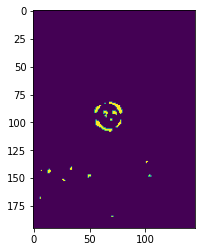

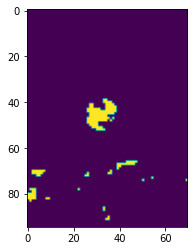

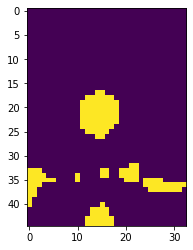

[INFO] Performing nms ... 


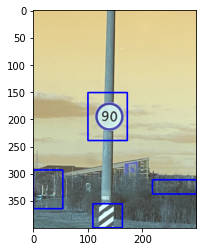

In [66]:
test_path = os.path.join(train_dir, 'road789.png')
threshold = 0.5
nms_threshold = 0.3
scale_factor = 2.0
min_img_size = 48

print(pnet.summary())
if(os.path.exists(pnet_weights)):
    print('[INFO] Loading P-Net pretrained weights ...')
    pnet.load_weights(pnet_weights)

raw_img = cv2.imread(test_path)
H, W = raw_img.shape[:2]

images = [raw_img]
current_h, current_w = raw_img.shape[:2]
while(current_h > min_img_size and current_w > min_img_size):
    current_h = int(current_h / scale_factor)
    current_w = int(current_w / scale_factor)
    
    if(current_w < min_img_size or current_h < min_img_size) : break
    
    image = cv2.resize(raw_img, (current_w, current_h))
    images.append(image)
    
boxes = []
for i, image in enumerate(images):
    if(i == 0): scale = 1
    else : scale = scale_factor ** i
        
    img = (image - 127.5) / 127.5
    height, width = image.shape[:2]

    predictions = pnet.predict(np.array([img]))
    features_shape = predictions[1][0].shape[:2]
    
    scale_w = width / features_shape[1]
    scale_h = height / features_shape[0]
    
    bboxes = predictions[1][0]
    raw_bboxes = bboxes
    confidence = predictions[0][0]

    ### Showing confidence map ###
    conf_map = confidence[:, :, 1]
    conf_map[conf_map > 0.7] = 255
    conf_map[conf_map <= 0.7] = 0
    conf_map = (conf_map * 255).astype(np.uint8)
    contours, hierarchy = cv2.findContours(conf_map, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        rect = cv2.boundingRect(contour)
        x, y, w, h = (rect * np.array([W/conf_map.shape[1],H/conf_map.shape[0],W/conf_map.shape[1],H/conf_map.shape[0] ])).astype(int)
        
        if(w * h < (W * H)/64): continue
        boxes.append([x,y,w,h])
        
    plt.imshow(conf_map)
    plt.show()
        
print('[INFO] Performing nms ... ')
pick = __nms(np.array(boxes), np.ones((len(boxes))), nms_threshold, 'Min')
crops = []
bboxes = []
for i in pick:#range(len(boxes)):
    x,y,w,h = boxes[i]
    
    crop = raw_img[y:y+h, x:x+w]
    cv2.rectangle(raw_img, (x,y), (x+w, y+h), (0,0,255),2)
    
    crops.append(crop)
    bboxes.append((x,y,w,h))
    
plt.imshow(raw_img)
plt.show()

# Fine-tuning with R-Net

[array([[0., 0., 1., 1.]], dtype=float32), array([[3.9686716e-11, 1.0000000e+00]], dtype=float32)]
[array([[0.0000000e+00, 0.0000000e+00, 1.0645524e-28, 1.0000000e+00]],
      dtype=float32), array([[0.00350713, 0.9964929 ]], dtype=float32)]


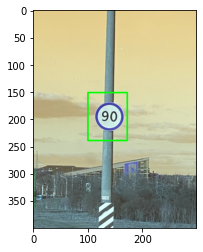

In [67]:
rnet_bboxes = []
for (crop, (x,y,w,h)) in zip(crops, bboxes):    
    H, W = crop.shape[:2]
    crop_ = cv2.resize(crop, (input_dim[0], input_dim[1]))
    prediction = rnet.predict(np.array([crop_]))
    
    bbox = prediction[0][0]
    confidence = prediction[1][:,1]
    
    if(confidence < 0.7):
        continue
        
    x_, y_, w, h = (bbox * np.array([W, H, W, H])).astype(np.uint8)
    x += x_
    y += y_
    
    rnet_bboxes.append((x, y, w, h))
        
raw_img = cv2.imread(test_path)

for (x, y, w, h) in rnet_bboxes:
    cv2.rectangle(raw_img, (x, y), (x+w, y+h), (0,255,0), 2)

plt.imshow(raw_img)
plt.show()